* PAPER - AN IMAGE IS WORTH 16X16 WORDS : TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE - [PDF](https://arxiv.org/pdf/2010.11929.pdf)
* PAPER - Vision Transformer for Small-Size Datasets - [PDF](https://arxiv.org/pdf/2112.13492v1.pdf)

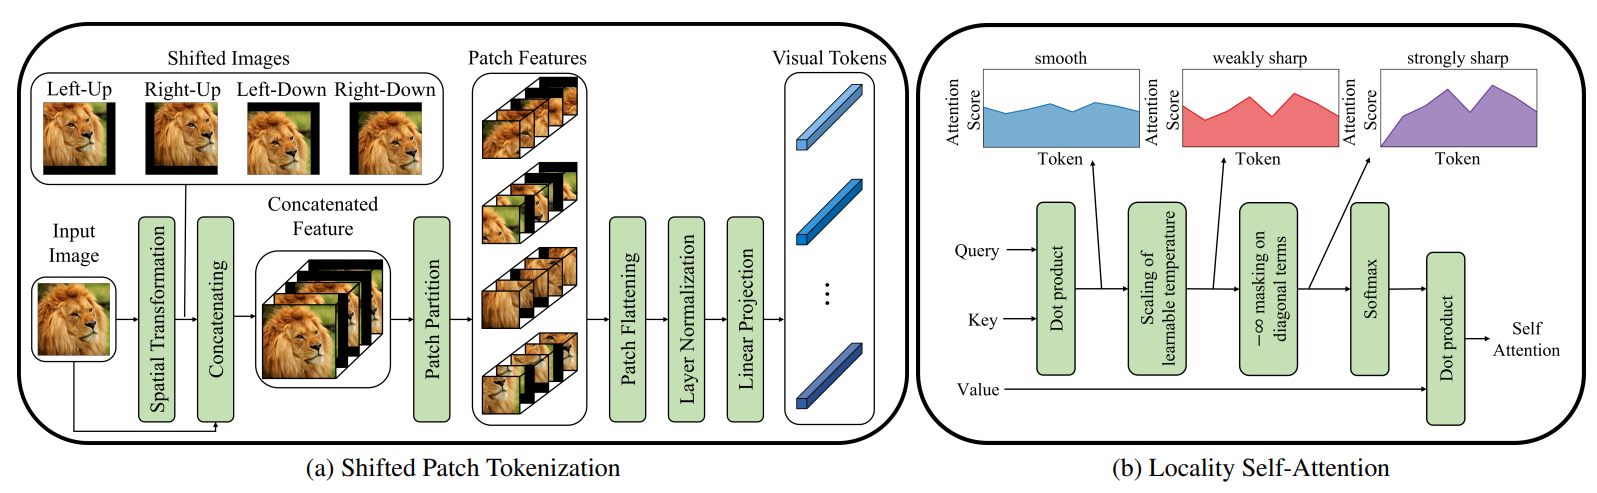

# 준비

## 라이브러리 호출

In [2]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## 데이터

In [3]:
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## 하이퍼 파라미터

In [17]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 64

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [PROJECTION_DIM * 2,PROJECTION_DIM,]
MLP_HEAD_UNITS = [2048, 1024]

## 증강

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

# 모델

## Shifted Patch Tokenization

In [19]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

### Sample

Vanilla patch


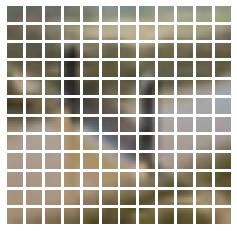

ORIGINAL


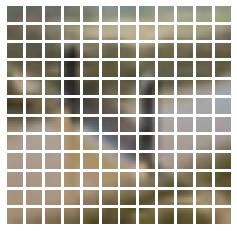

LEFT-UP


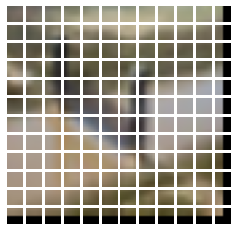

LEFT-DOWN


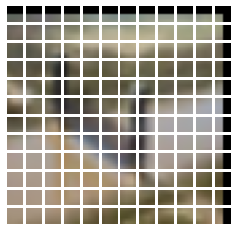

RIGHT-UP


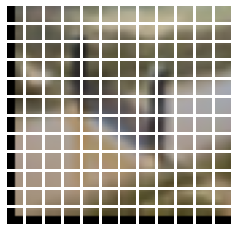

RIGHT-DOWN


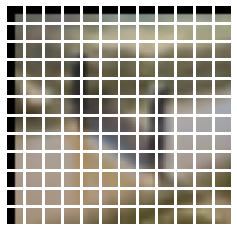

In [20]:
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
print("Vanilla patch")
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## Patch Encoding 층

In [21]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding( input_dim=num_patches, output_dim=projection_dim)
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

## MHA LSA

In [22]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

## MLP

In [23]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Build Model

In [24]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## warmup_cosine

In [25]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

# 컴파일 및 훈련

In [26]:
def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [27]:
# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

Epoch 1/50
704/704 [==============================] - 87s 113ms/step - loss: 4.4710 - accuracy: 0.0383 - top-5-accuracy: 0.1470 - val_loss: 3.9557 - val_accuracy: 0.0928 - val_top-5-accuracy: 0.2938
Epoch 2/50
704/704 [==============================] - 79s 112ms/step - loss: 4.0028 - accuracy: 0.0827 - top-5-accuracy: 0.2667 - val_loss: 3.6857 - val_accuracy: 0.1340 - val_top-5-accuracy: 0.3770
Epoch 3/50
704/704 [==============================] - 79s 112ms/step - loss: 3.6930 - accuracy: 0.1275 - top-5-accuracy: 0.3639 - val_loss: 3.2826 - val_accuracy: 0.2032 - val_top-5-accuracy: 0.4840
Epoch 4/50
704/704 [==============================] - 83s 119ms/step - loss: 3.4443 - accuracy: 0.1711 - top-5-accuracy: 0.4378 - val_loss: 3.1205 - val_accuracy: 0.2264 - val_top-5-accuracy: 0.5258
Epoch 5/50
704/704 [==============================] - 79s 113ms/step - loss: 3.2558 - accuracy: 0.2075 - top-5-accuracy: 0.4918 - val_loss: 2.9311 - val_accuracy: 0.2732 - val_top-5-accuracy: 0.5772
Epoch

704/704 [==============================] - 79s 113ms/step - loss: 1.8049 - accuracy: 0.5084 - top-5-accuracy: 0.8121 - val_loss: 1.9116 - val_accuracy: 0.4938 - val_top-5-accuracy: 0.7890
Epoch 43/50
704/704 [==============================] - 79s 113ms/step - loss: 1.7938 - accuracy: 0.5133 - top-5-accuracy: 0.8140 - val_loss: 1.9145 - val_accuracy: 0.4876 - val_top-5-accuracy: 0.7826
Epoch 44/50
704/704 [==============================] - 80s 113ms/step - loss: 1.7750 - accuracy: 0.5138 - top-5-accuracy: 0.8206 - val_loss: 1.9295 - val_accuracy: 0.4920 - val_top-5-accuracy: 0.7830
Epoch 45/50
704/704 [==============================] - 80s 114ms/step - loss: 1.7697 - accuracy: 0.5210 - top-5-accuracy: 0.8181 - val_loss: 1.9164 - val_accuracy: 0.4942 - val_top-5-accuracy: 0.7854
Epoch 46/50
704/704 [==============================] - 80s 113ms/step - loss: 1.7587 - accuracy: 0.5196 - top-5-accuracy: 0.8198 - val_loss: 1.9739 - val_accuracy: 0.4812 - val_top-5-accuracy: 0.7798
Epoch 47/50


In [28]:
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/50
704/704 [==============================] - 93s 121ms/step - loss: 4.4562 - accuracy: 0.0404 - top-5-accuracy: 0.1509 - val_loss: 3.9733 - val_accuracy: 0.0792 - val_top-5-accuracy: 0.2886
Epoch 2/50
704/704 [==============================] - 85s 121ms/step - loss: 4.0331 - accuracy: 0.0791 - top-5-accuracy: 0.2600 - val_loss: 3.7172 - val_accuracy: 0.1324 - val_top-5-accuracy: 0.3680
Epoch 3/50
704/704 [==============================] - 85s 121ms/step - loss: 3.8274 - accuracy: 0.1131 - top-5-accuracy: 0.3280 - val_loss: 3.5223 - val_accuracy: 0.1692 - val_top-5-accuracy: 0.4224
Epoch 4/50
704/704 [==============================] - 84s 120ms/step - loss: 3.6128 - accuracy: 0.1510 - top-5-accuracy: 0.3929 - val_loss: 3.2664 - val_accuracy: 0.2192 - val_top-5-accuracy: 0.4878
Epoch 5/50
704/704 [==============================] - 84s 120ms/step - loss: 3.4372 - accuracy: 0.1808 - top-5-accuracy: 0.4406 - val_loss: 3.0987 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.5246
Epoch

704/704 [==============================] - 84s 119ms/step - loss: 1.7628 - accuracy: 0.5202 - top-5-accuracy: 0.8192 - val_loss: 1.8813 - val_accuracy: 0.5014 - val_top-5-accuracy: 0.7880
Epoch 43/50
704/704 [==============================] - 85s 120ms/step - loss: 1.7480 - accuracy: 0.5246 - top-5-accuracy: 0.8212 - val_loss: 1.8012 - val_accuracy: 0.5208 - val_top-5-accuracy: 0.8066
Epoch 44/50
704/704 [==============================] - 85s 121ms/step - loss: 1.7397 - accuracy: 0.5270 - top-5-accuracy: 0.8224 - val_loss: 1.8131 - val_accuracy: 0.5134 - val_top-5-accuracy: 0.8108
Epoch 45/50
704/704 [==============================] - 86s 122ms/step - loss: 1.7250 - accuracy: 0.5288 - top-5-accuracy: 0.8248 - val_loss: 1.7687 - val_accuracy: 0.5130 - val_top-5-accuracy: 0.8130
Epoch 46/50
704/704 [==============================] - 85s 121ms/step - loss: 1.7208 - accuracy: 0.5317 - top-5-accuracy: 0.8253 - val_loss: 1.8411 - val_accuracy: 0.5110 - val_top-5-accuracy: 0.7994
Epoch 47/50
